In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("../input/av-healthcare2/train.csv")
test =  pd.read_csv("../input/av-healthcare2/test.csv")
sample_sub =  pd.read_csv("../input/av-healthcare2/sample_submission.csv")
desc =  pd.read_csv("../input/av-healthcare2/train_data_dict.csv")
test_copy = test

In [3]:
train.head(2).append(train.head(2))

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50


In [4]:
train['Bed Grade'] = train['Bed Grade'].fillna(method="ffill",axis=0)
train['City_Code_Patient'] = train['City_Code_Patient'].fillna(method="ffill",axis=0)      

test['Bed Grade'] = test['Bed Grade'].fillna(method="ffill",axis=0)
test['City_Code_Patient'] = test['City_Code_Patient'].fillna(method="ffill",axis=0)

train['Bed Grade'] = train['Bed Grade'].astype(np.int64)                        
test['City_Code_Patient'] = test['City_Code_Patient'].astype(np.int64)

train['is_train'] = 1
test['is_train'] = 0
test['Stay'] = None
print(train.shape, test.shape)

(318438, 19) (137057, 19)


In [5]:
import category_encoders as ce

df_data = pd.concat((train,test))

encoder = ce.OrdinalEncoder(return_df = True)
df_data['Ward_Facility_Code'] = encoder.fit_transform(df_data['Ward_Facility_Code'])        # Using ordinal encoders to encode categorical variables 
  
encoder = ce.OrdinalEncoder(return_df = True)
df_data['Type of Admission'] = encoder.fit_transform(df_data['Type of Admission'])

encoder = ce.OrdinalEncoder(return_df = True)
df_data['Severity of Illness'] = encoder.fit_transform(df_data['Severity of Illness'])

val = { '0-10':1, '11-20': 2,'21-30':3,'31-40':4,'41-50':5,'51-60':6,'61-70':7,'71-80':8,'81-90':9,'91-100':10   }
df_data['Age'] = df_data['Age'].map(val)
df_data['Age'].value_counts()

5     91495
4     90420
6     69506
3     58560
8     50737
7     48619
2     23871
9     11240
1      9140
10     1907
Name: Age, dtype: int64

In [6]:
val1 = { 1:'Young', 2: 'Young',3:'Adult',4:'Adult',5:'Adult',6:'Aged',7:'Aged',8:'Aged',9:'Aged',10:'Aged'   }
df_data['Age_group'] = df_data['Age'].map(val1)

df_data['Age_group'].value_counts()

Adult    240475
Aged     182009
Young     33011
Name: Age_group, dtype: int64

In [7]:
ob_col = df_data.select_dtypes(['object']).columns.tolist()   # Selecting object features for label encoding 

ob_col.remove("Stay")
le = preprocessing.LabelEncoder() 

for col in ob_col:
    df_data[col] = le.fit_transform(df_data[col])

df_data.head(2)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train,Age_group
0,1,8,2,3,2,3,3,2,1,2.0,31397,7.0,1,1,2,6,4911.0,0-10,1,1
1,2,2,2,5,2,2,3,3,1,2.0,31397,7.0,2,1,2,6,5954.0,41-50,1,1


In [8]:
cat=test_copy.select_dtypes(['object']).columns.tolist()
cat.append('Age_group')
cat

['Hospital_type_code',
 'Hospital_region_code',
 'Department',
 'Ward_Type',
 'Ward_Facility_Code',
 'Type of Admission',
 'Severity of Illness',
 'Age',
 'Stay',
 'Age_group']

In [9]:
df_data['Unique_hosp_per_patient']=df_data.groupby(['patientid'])['Hospital_code'].transform('nunique') 
df_data['Unique_patitent_per_hosp']=df_data.groupby(['Hospital_code'])['patientid'].transform('nunique') 
df_data['hosp_per_city']=df_data.groupby(['City_Code_Hospital'])['Hospital_code'].transform('nunique') 
df_data['total_hosp_city_same_type']=df_data.groupby(['City_Code_Hospital'])['Hospital_type_code'].transform('nunique') 
df_data['Ward_Type_Severity of Illness'] = df_data.groupby(['Ward_Type','Severity of Illness'])['patientid'].transform('nunique')
df_data['Unique_dept_per_patient']=df_data.groupby(['patientid'])['Department'].transform('nunique') 
df_data['Severity of Illness_dept'] = df_data.groupby(['Severity of Illness','Department'])['patientid'].transform('nunique')
df_data['Severity of Illness_age_grp'] = df_data.groupby(['Severity of Illness','Age_group'])['patientid'].transform('nunique')
df_data['hos_vis_diffcity'] = df_data.groupby('patientid')['City_Code_Hospital'].transform('nunique') 
df_data['visit_same_hos_type'] = df_data.groupby('patientid')['Hospital_type_code'].transform('count') 
df_data['Severity of Illness_age'] = df_data.groupby(['Severity of Illness','Age'])['patientid'].transform('count')
df_data['total_cases_per_patient'] = df_data.groupby('patientid')['case_id'].transform('count')
df_data['visit_same_hos'] = df_data.groupby('Hospital_code')['patientid'].transform('count') 
df_data['freq_patients'] = df_data.groupby('patientid')['patientid'].transform('count') 
df_data['visit_same_dep_type'] = df_data.groupby('patientid')['Department'].transform('count') 
df_data['mean_admission'] = df_data.groupby('patientid')['Admission_Deposit'].transform('mean') 
df_data['bill_per_patitent']=df_data.groupby(['patientid'])['Admission_Deposit'].transform('sum') 
df_data['median_admission'] = df_data.groupby('patientid')['Admission_Deposit'].transform('median') 
df_data['min_Severity of Illness_pat'] = df_data.groupby('patientid')['Severity of Illness'].transform('min')
df_data['max_Severity of Illness_pat'] = df_data.groupby('patientid')['Severity of Illness'].transform('max')
df_data['max_bed_pat'] = df_data.groupby(['patientid'])['Bed Grade'].transform('max')
df_data['max_vis_pat'] = df_data.groupby(['patientid'])['Visitors with Patient'].transform('max')


df_data.isnull().sum()

case_id                                   0
Hospital_code                             0
Hospital_type_code                        0
City_Code_Hospital                        0
Hospital_region_code                      0
Available Extra Rooms in Hospital         0
Department                                0
Ward_Type                                 0
Ward_Facility_Code                        0
Bed Grade                                 0
patientid                                 0
City_Code_Patient                         0
Type of Admission                         0
Severity of Illness                       0
Visitors with Patient                     0
Age                                       0
Admission_Deposit                         0
Stay                                 137057
is_train                                  0
Age_group                                 0
Unique_hosp_per_patient                   0
Unique_patitent_per_hosp                  0
hosp_per_city                   

In [10]:
df_data['Age_group'] = df_data['Age_group'].astype("int64")


df_train, df_test = df_data[df_data.is_train == 1], df_data[df_data.is_train == 0]
df_train.drop(['is_train'], inplace=True, axis=1)                   # Splitting back train and set sets 
df_test.drop(['is_train'], inplace=True, axis=1)
df_test.drop(['Stay'], inplace=True, axis=1)

le = preprocessing.LabelEncoder()
df_train['Stay'] = le.fit_transform(df_train['Stay'])

df_train['Stay'] = df_train['Stay'].astype(int)
corr_m = df_train.corr()                                # Checking correlation between target and features 
corr_m['Stay'].sort_values(ascending = True)

max_Severity of Illness_pat         -0.130233
Severity of Illness                 -0.126160
Available Extra Rooms in Hospital   -0.121120
min_Severity of Illness_pat         -0.119492
Unique_hosp_per_patient             -0.062588
median_admission                    -0.061748
case_id                             -0.053882
Ward_Type_Severity of Illness       -0.053277
Admission_Deposit                   -0.052077
mean_admission                      -0.050380
Ward_Facility_Code                  -0.027239
Severity of Illness_age_grp         -0.023907
Severity of Illness_dept            -0.013659
hosp_per_city                       -0.012206
Severity of Illness_age             -0.009612
City_Code_Patient                   -0.009565
max_bed_pat                         -0.008853
hos_vis_diffcity                    -0.003630
bill_per_patitent                   -0.000593
patientid                            0.001125
total_hosp_city_same_type            0.004385
City_Code_Hospital                

In [11]:
X = df_train.drop(['Stay','case_id','patientid'],axis=1)
y = df_train['Stay']

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True, stratify=df_train['Stay'])
feature_cols = df_train.columns.tolist()
feature_cols.remove('Stay')
feature_cols.remove('case_id')
feature_cols.remove('patientid')


label_col = 'Stay'
print("Feature cols")
print(" ")
print(feature_cols)
print(" ")
print('Catagorical columns')
print(" ")
cat_cols = cat
print(cat_cols)

Feature cols
 
['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit', 'Age_group', 'Unique_hosp_per_patient', 'Unique_patitent_per_hosp', 'hosp_per_city', 'total_hosp_city_same_type', 'Ward_Type_Severity of Illness', 'Unique_dept_per_patient', 'Severity of Illness_dept', 'Severity of Illness_age_grp', 'hos_vis_diffcity', 'visit_same_hos_type', 'Severity of Illness_age', 'total_cases_per_patient', 'visit_same_hos', 'freq_patients', 'visit_same_dep_type', 'mean_admission', 'bill_per_patitent', 'median_admission', 'min_Severity of Illness_pat', 'max_Severity of Illness_pat', 'max_bed_pat', 'max_vis_pat']
 
Catagorical columns
 
['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'S

In [12]:

params = {}
params['learning_rate'] = 0.06
params['max_depth'] = 50
params['n_estimators'] = 500
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.6
params['reg_lambda'] = 1.1

In [13]:
clf = lgb.LGBMClassifier( **params ,n_jobs = -1, is_unbalanced = True)

clf.fit(X_train, y_train, eval_metric='multi_error', verbose=False)

eval_score_acc = accuracy_score(y_test, clf.predict(X_test))

print('ACC: {}'.format(eval_score_acc))

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
ACC: 0.43413725243897333


In [14]:
clf = lgb.LGBMClassifier(**params,n_jobs= -1)
score = cross_val_score(clf , X_train, y_train , cv = 5 , n_jobs = -1,verbose = 1 )
score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.4min finished


array([0.43293257, 0.43253853, 0.42827662, 0.43011597, 0.43247123])

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


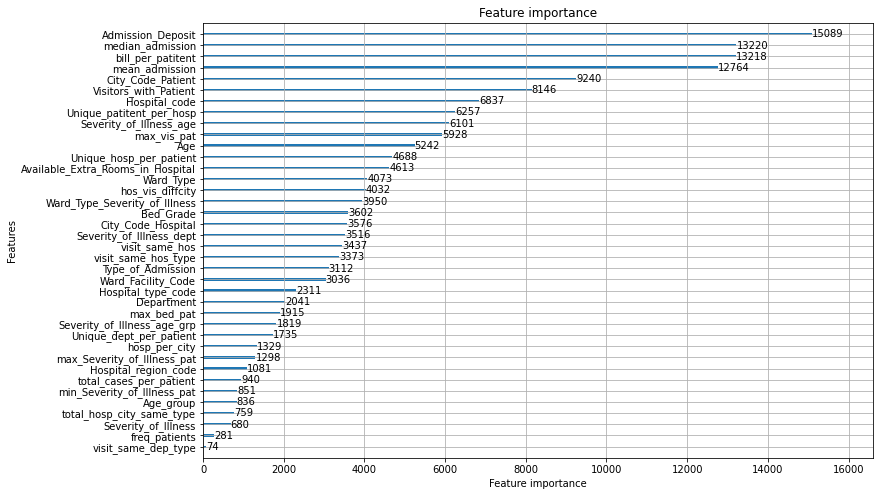

In [15]:
clf = lgb.LGBMClassifier( **params ,n_jobs = -1, is_unbalanced = True, )

clf.fit(X, y, eval_metric='multi_error', verbose=False)

df_test = df_test.drop(['case_id','patientid'],axis=1)
lgbm= clf.predict_proba(df_test)
plt.rcParams['figure.figsize'] = (12,8)
lgb.plot_importance(clf)
plt.show() 

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2,k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores['Score'] = round(featureScores['Score'],2)
featureScores.sort_values(by = 'Score', ascending= False)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2,k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores['Score'] = round(featureScores['Score'],2)
featureScores.sort_values(by = 'Score', ascending= False)

,Features,Score
32,bill_per_patitent,21857380.08
28,visit_same_hos,9243039.92
20,Ward_Type_Severity of Illness,8616473.79
17,Unique_patitent_per_hosp,7043121.58
26,Severity of Illness_age,5035822.53
22,Severity of Illness_dept,3752587.01
23,Severity of Illness_age_grp,2549650.04
14,Admission_Deposit,1116661.78
33,median_admission,301530.39
31,mean_admission,220428.16


In [17]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(loss_function = 'MultiClass', objective= 'MultiClass',learning_rate = 0.09,
                        eval_metric = 'Accuracy', early_stopping_rounds=20 )


score = cross_val_score(cb  , X_train, y_train , cv = 5 , n_jobs = -1,verbose = 0 )
cb.fit(X,y,silent = True) 
cat_boost = cb.predict_proba(df_test)

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
0:	learn: 0.3819620	total: 1.64s	remaining: 27m 21s
1:	learn: 0.3825957	total: 4.46s	remaining: 37m 4s
2:	learn: 0.3821807	total: 7.09s	remaining: 39m 16s
3:	learn: 0.3851753	total: 9.94s	remaining: 41m 14s
4:	learn: 0.3885287	total: 12.7s	remaining: 42m 15s
5:	learn: 0.3899812	total: 15.4s	remaining: 42m 28s
6:	learn: 0.3906990	total: 18s	remaining: 42m 28s
7:	learn: 0.3908560	total: 20.7s	remaining: 42m 51s
8:	learn: 0.3913495	total: 23.4s	remaining: 42m 59s
9:	learn: 0.3917644	total: 26.1s	remaining: 43m 2s
10:	learn: 0.3923084	total: 28.9s	remaining: 43m 18s
11:	learn: 0.3940412	total: 31.6s	remaining: 43m 21s
12:	learn: 0.3948880	total: 34.3s	remaining: 43m 24s
13:	learn: 0.3956170	total: 37.3s	remaining: 43m 45s
14:	learn: 0.3961834	total: 

In [20]:
w1 = 0.6
w2 = 0.4

final = (w1*cat_boost) + (w2*lgbm) 
label = clf.classes_
label = label.tolist()
blend = np.argmax(final,axis = 1)

preds = le.inverse_transform(blend) 


test1 = test_copy
submit = pd.DataFrame({'case_id': test1.case_id, 'Stay': preds})
print(submit)
submit.to_csv('blend_lgbm_cb.csv', index=False)

        case_id   Stay
0        318439   0-10
1        318440  51-60
2        318441  21-30
3        318442  21-30
4        318443  51-60
...         ...    ...
137052   455491  21-30
137053   455492   0-10
137054   455493  21-30
137055   455494  11-20
137056   455495  51-60

[137057 rows x 2 columns]
